In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 30.2 MB/s 
     |████████████████████████████████| 7.6 MB 55.3 MB/s 
     |████████████████████████████████| 182 kB 75.9 MB/s 


In [2]:
import os
import ast
import torch
import pickle
import requests
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from typing import Tuple, List
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta, FR
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.ticker as mticker

MODEL_PATH = "ipuneetrathore/bert-base-cased-finetuned-finBERT"
MAX_LEN = 256
BATCH_SIZE = 8
pd.set_option('chained_assignment', None)

In [3]:
class FinBertCased:
    def __init__(self, max_len: int, batch_size: int, model_path: str):
        self.max_len = max_len
        self.model_path = model_path
        self.batch_size= batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_path).eval().to('cuda')
        self.label_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
        self.inverse_label_dict = {v: k for k, v in self.label_dict.items()}

    def full_preprocess(self, text: List[str]): # Tuple[torch.Tensor, torch.Tensor]
        """ Preprocessing pipeline from string to ids and attention mask. """
        encoded = self.tokenizer(text, 
                                 add_special_tokens=True,
                                 max_length=self.max_len,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 return_tensors='pt',
                                 truncation=True)
        input_ids = torch.cat([encoded['input_ids']], dim=0).to('cuda')
        attention_mask = torch.cat([encoded['attention_mask']], dim=0).to('cuda')
        return input_ids, attention_mask

    def predict_raw(self, text: List[str]): # torch.Tensor
        """ Predict raw logits """
        input_ids, attention_mask = self.full_preprocess(text)
        model_output = self.model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = model_output[0]
        return logits

    def predict_score(self, text: List[str]): # np.float32
        """ Predict a single sentiment score (positive_sentiment - negative_sentiment) """
        logits = self.predict_raw(text)
        softmax_output = F.softmax(logits, dim=1).cpu().detach().numpy()
        pos_idx = self.inverse_label_dict['positive']
        neg_idx = self.inverse_label_dict['negative']
        return softmax_output[:, pos_idx] - softmax_output[:, neg_idx]

    def predict_signals(self, text: pd.Series): # List[float]
        """
        Get ranking of average sentiment scores for every ticker in the data.
        :param text: Pandas Series of articles grouped by week and ticker
        :return: Scaled sentiment scores in range [0...1]
        """
        sent_scores = []
        for row in tqdm(text):
            sents = row[:-1]
            sent_scores_ticker = []
            for batch in self._chunks(sents, self.batch_size):
                batch_sents = self.predict_score(batch)
                sent_scores_ticker.append(batch_sents)
                
            mean_score = np.array(np.concatenate(sent_scores_ticker)).ravel().mean()
            sent_scores.append(mean_score)
        signals = self._scale_sentiment(sent_scores)
        return signals
    
    @staticmethod
    def _chunks(lst, n):
        """ Yield successive n-sized chunks from list. """
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    @staticmethod
    def _scale_sentiment(sentiments: List[float]):
        """ Scale sentiment scores from [-1...1] to [0...1] """
        mm = MinMaxScaler()
        sent_proc = np.array(sentiments).reshape(-1, 1)
        return mm.fit_transform(sent_proc)

In [4]:
fbc = FinBertCased(max_len=MAX_LEN, batch_size=BATCH_SIZE, model_path=MODEL_PATH)
# proc_data.loc[:, 'signal'] = fbc.predict_signals(proc_data['title'])

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/456123.csv', encoding='unicode_escape')

In [6]:
df.loc[:, 'signal'] = fbc.predict_signals(df['title'])

100%|██████████| 9806/9806 [23:11<00:00,  7.05it/s]


In [7]:
ssuumm = df.groupby(['date'])['signal'].agg('mean')

In [14]:
dataframes = pd.DataFrame({
              'Sentiment_Mean': df.groupby(['date'])['signal'].agg('mean'),
              'Sentiment_SD': df.groupby(['date'])['signal'].agg('std'),
              'Sentiment_Min': df.groupby(['date'])['signal'].agg('min'),
              'Sentiment_Max': df.groupby(['date'])['signal'].agg('max'),
              'Sentiment_Median': df.groupby(['date'])['signal'].agg('median')
              }, index = ssuumm.index)

In [15]:
dataframes

,Sentiment_Mean,Sentiment_SD,Sentiment_Min,Sentiment_Max,Sentiment_Median
date,,,,,
2017/1/17,0.624821,0.000005,0.624818,0.624826,0.624818
2017/1/18,0.624818,0.000002,0.624816,0.624820,0.624817
2017/1/19,0.624816,NaN,0.624816,0.624816,0.624816
2017/1/23,0.624813,NaN,0.624813,0.624813,0.624813
2017/1/24,0.624846,0.000044,0.624815,0.624878,0.624846
...,...,...,...,...,...
2022/9/5,0.624936,0.000167,0.624818,0.625055,0.624936
2022/9/6,0.624860,0.000068,0.624817,0.624960,0.624832
2022/9/7,0.619902,0.011000,0.600224,0.624823,0.624821


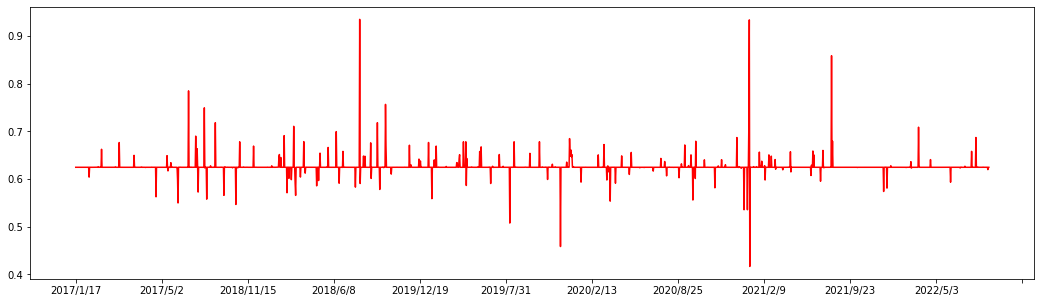

In [16]:
fig = plt.figure(figsize= (18,5))
ax = fig.add_subplot()
ax.xaxis.set_major_locator(mticker.MultipleLocator(180))
ax.plot(dataframes['Sentiment_Mean'].index, dataframes['Sentiment_Mean'],color = 'red', label = 'Real', markerfacecolor = 'red', markersize = 6)

In [17]:
from google.colab import files
dataframes.to_csv('scores1.csv')
files.download('scores1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>